---
title: "Hyperparameter Tuning for Physics-Informed Neural Networks"
subtitle: "Using SpotOptim to Optimize PINN Architecture and Training"
format:
  html:
    code-fold: false
    toc: true
    number-sections: true
jupyter: python3
---

# Overview

This tutorial demonstrates how to use SpotOptim for hyperparameter optimization of Physics-Informed Neural Networks (PINNs). We'll optimize the network architecture and training parameters to find the best configuration for solving an ordinary differential equation.

Building on the basic PINN demo, we'll now systematically search for optimal:

- Number of neurons per hidden layer
- Number of hidden layers
- Activation function (categorical)
- Optimizer algorithm (categorical)
- Learning rate (log-scale)
- Physics loss weight (log-scale)

## Key Features

### 1. PyTorch Dataset and DataLoader

Following PyTorch best practices from the [official tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html), this tutorial implements:

- **Custom Dataset Classes**: Separate classes for supervised data (`PINNDataset`) and collocation points (`CollocationDataset`)
- **DataLoader Integration**: Efficient batch processing with configurable batch size, shuffling, and parallel loading
- **Proper Data Separation**: Clean separation of training, validation, and collocation data
- **Gradient Tracking**: Automatic gradient handling for collocation points needed in physics loss

Benefits:

- **Modularity**: Clean separation between data and model code
- **Efficiency**: Batch processing and optional parallel data loading
- **Scalability**: Easy to extend to larger datasets
- **Best Practices**: Follows PyTorch conventions used across the ecosystem

### 2. Automatic Transformation Handling

This tutorial also showcases SpotOptim's `var_trans` feature for automatic variable transformations. Learning rates and regularization parameters are often best explored on a log scale, but manually transforming values is tedious and error-prone. With `var_trans`, you simply specify:

```python
var_trans = [None, None, "log10", "log10"]
```

SpotOptim then:

- Optimizes internally in log-transformed space (efficient exploration)
- Passes original-scale values to your objective function (no manual conversion needed)
- Displays all results in original scale (easy interpretation)

This eliminates the need for manual `10**x` conversions throughout your code!

# The Problem

We're solving the same ODE as in the basic PINN demo:

$$
\frac{dy}{dt} + 0.1 y - \sin\left(\frac{\pi t}{2}\right) = 0
$$

with initial condition $y(0) = 0$.

# Setup

In [1]:
#| label: setup-pinn2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from typing import Tuple
from spotoptim import SpotOptim
from spotoptim.nn.linear_regressor import LinearRegressor

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set number of epochs for training
N_EPOCHS=5000

# 
MAX_ITER = 50

# Data Generation

Following PyTorch best practices, we'll create custom Dataset classes for our PINN data.

## Custom Dataset Classes

We'll create two dataset types:

1. `PINNDataset` for supervised data (training and validation)
2. `CollocationDataset` for physics-informed collocation points

In [2]:
#| label: data-generation-pinn2
from torch.utils.data import Dataset, DataLoader

def oscillator(
    n_steps: int = 3000,
    t_min: float = 0.0,
    t_max: float = 30.0,
    y0: float = 0.0,
    alpha: float = 0.1,
    omega: float = np.pi / 2
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Solve ODE: dy/dt + alpha*y - sin(omega*t) = 0
    using RK2 (midpoint method).
    
    Returns:
        t_tensor: Time points, shape (n_steps, 1)
        y_tensor: Solution values, shape (n_steps, 1)
    """
    t_step = (t_max - t_min) / n_steps
    t_points = np.arange(t_min, t_min + n_steps * t_step, t_step)[:n_steps]
    
    y = [y0]
    
    for t_current_step_end in t_points[1:]:
        t_midpoint = t_current_step_end - t_step / 2.0
        y_prev = y[-1]
        
        slope_at_t_mid = -alpha * y_prev + np.sin(omega * t_midpoint)
        y_intermediate = y_prev + (t_step / 2.0) * slope_at_t_mid
        
        slope_at_t_end = -alpha * y_intermediate + np.sin(omega * t_current_step_end)
        y_next = y_prev + t_step * slope_at_t_end
        y.append(y_next)
    
    t_tensor = torch.tensor(t_points, dtype=torch.float32).view(-1, 1)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    return t_tensor, y_tensor


class PINNDataset(Dataset):
    """PyTorch Dataset for PINN supervised data (training/validation).
    
    This dataset stores time-solution pairs (t, y) for supervised learning.
    
    Args:
        t (torch.Tensor): Time points, shape (n_samples, 1)
        y (torch.Tensor): Solution values, shape (n_samples, 1)
    """
    
    def __init__(self, t: torch.Tensor, y: torch.Tensor):
        self.t = t
        self.y = y
        
    def __len__(self) -> int:
        return len(self.t)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.t[idx], self.y[idx]


class CollocationDataset(Dataset):
    """PyTorch Dataset for PINN collocation points.
    
    This dataset stores time points where physics loss is evaluated.
    Gradients are required for computing derivatives in the PDE.
    
    Args:
        t (torch.Tensor): Collocation time points, shape (n_points, 1)
    """
    
    def __init__(self, t: torch.Tensor):
        # Store collocation points with gradient tracking
        self.t = t.requires_grad_(True)
        
    def __len__(self) -> int:
        return len(self.t)
    
    def __getitem__(self, idx: int) -> torch.Tensor:
        # Return single collocation point (still requires_grad)
        return self.t[idx].unsqueeze(0)

Generate exact solution using RK2

In [3]:
x_exact, y_exact = oscillator()

# Create training data (sparse sampling)
t_train = x_exact[0:3000:119]
y_train = y_exact[0:3000:119]

# Create validation data (different sampling for unbiased evaluation)
t_val = x_exact[50:3000:120]
y_val = y_exact[50:3000:120]

# Create collocation points for physics loss
t_physics = torch.linspace(0, 30, 50).view(-1, 1)

# Create Dataset objects
train_dataset = PINNDataset(t_train, y_train)
val_dataset = PINNDataset(t_val, y_val)
collocation_dataset = CollocationDataset(t_physics)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Collocation dataset size: {len(collocation_dataset)}")
print(f"\nSample from training dataset:")
t_sample, y_sample = train_dataset[0]
print(f"  t: {t_sample.item():.4f}, y: {y_sample.item():.4f}")

Training dataset size: 26
Validation dataset size: 25
Collocation dataset size: 50

Sample from training dataset:
  t: 0.0000, y: 0.0000


# Define the PINN Training Function

This function creates DataLoaders and trains a PINN with given hyperparameters.
Following PyTorch best practices, we use DataLoader for efficient batch processing.

In [4]:
#| label: pinn-training-function-pinn2
def train_pinn(
    l1: int,
    num_layers: int,
    activation: str,
    optimizer_name: str,
    lr_unified: float,
    alpha: float,
    n_epochs: int = N_EPOCHS,
    batch_size: int = 16,
    verbose: bool = False
) -> float:
    """
    Train a PINN with specified hyperparameters using DataLoaders.
    
    Args:
        l1: Number of neurons per hidden layer
        num_layers: Number of hidden layers
        activation: Activation function ("Tanh", "ReLU", "Sigmoid", "GELU")
        optimizer_name: Optimizer algorithm ("Adam", "SGD", "RMSprop", "AdamW")
        lr_unified: Unified learning rate multiplier
        alpha: Weight for physics loss
        n_epochs: Number of training epochs
        batch_size: Batch size for DataLoader
        verbose: Whether to print progress
    
    Returns:
        Validation mean squared error
    """
    # Set seed for reproducibility
    torch.manual_seed(42)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    # For collocation points, we can use full batch since it's small
    collocation_loader = DataLoader(
        collocation_dataset,
        batch_size=len(collocation_dataset),
        shuffle=False,
        num_workers=0
    )
    
    # Create model
    model = LinearRegressor(
        input_dim=1,
        output_dim=1,
        l1=l1,
        num_hidden_layers=num_layers,
        activation=activation,
        lr=lr_unified
    )
    
    # Get optimizer
    optimizer = model.get_optimizer(optimizer_name)
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        
        # Get collocation points (full batch)
        t_physics_batch = next(iter(collocation_loader))
        # Ensure gradients are enabled
        t_physics_batch = t_physics_batch.requires_grad_(True)
        
        # Iterate over training batches
        for batch_t, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Data Loss
            y_pred = model(batch_t)
            loss_data = torch.mean((y_pred - batch_y)**2)
            
            # Physics Loss (computed on full collocation set)
            y_physics = model(t_physics_batch)
            dy_dt = torch.autograd.grad(
                y_physics,
                t_physics_batch,
                torch.ones_like(y_physics),
                create_graph=True,
                retain_graph=True
            )[0]
            
            # PDE residual: dy/dt + 0.1*y - sin(pi*t/2) = 0
            physics_residual = dy_dt + 0.1 * y_physics - torch.sin(np.pi * t_physics_batch / 2)
            loss_physics = torch.mean(physics_residual**2)
            
            # Total Loss
            loss = loss_data + alpha * loss_physics
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        if verbose and (epoch + 1) % 2000 == 0:
            avg_loss = epoch_loss / len(train_loader)
            print(f"  Epoch {epoch+1}/{n_epochs}: Avg Loss = {avg_loss:.6f}")
    
    # Evaluate on validation set
    model.eval()
    val_mse = 0.0
    with torch.no_grad():
        for batch_t, batch_y in val_loader:
            y_pred = model(batch_t)
            val_mse += torch.mean((batch_y - y_pred)**2).item()
    
    val_mse /= len(val_loader)
    return val_mse

# Test the function with default parameters
print("Testing PINN training function with DataLoaders...")
test_error = train_pinn(
    l1=32, 
    num_layers=2,
    activation="Tanh",
    optimizer_name="Adam",
    lr_unified=3.0, 
    alpha=0.06,
    batch_size=16,
    n_epochs=N_EPOCHS, 
    verbose=True
)
print(f"\nTest validation MSE: {test_error:.6f}")

Testing PINN training function with DataLoaders...
  Epoch 2000/5000: Avg Loss = 0.185009
  Epoch 4000/5000: Avg Loss = 0.153585

Test validation MSE: 0.130621


# Hyperparameter Optimization with SpotOptim

Now we'll use SpotOptim to find the best hyperparameters:

## Define the Objective Function

In [5]:
#| label: pinn-objective-function-pinn2
def objective_pinn(X):
    """
    Objective function for SpotOptim.
    
    Args:
        X: Array of hyperparameter configurations, shape (n_configs, 6)
           Each row: [l1, num_layers, activation, optimizer, lr_unified, alpha]
           Note: SpotOptim handles log transformations and factor mapping automatically
    
    Returns:
        Array of validation errors
    """
    results = []
    
    for i, params in enumerate(X):
        # Extract parameters (already in original scale thanks to var_trans)
        # Factor variables (activation, optimizer) are returned as strings
        l1 = int(params[0])                    # Number of neurons
        num_layers = int(params[1])            # Number of hidden layers
        activation = params[2]                 # Activation function
        optimizer_name = params[3]             # Optimizer algorithm
        lr_unified = params[4]                 # Learning rate
        alpha = params[5]                      # Physics weight
        
        print(f"\nConfiguration {i+1}/{len(X)}:")
        print(f"  l1={l1}, num_layers={num_layers}, activation={activation}, ")
        print(f"  optimizer={optimizer_name}, lr_unified={lr_unified:.4f}, alpha={alpha:.4f}")
        
        # Train PINN with these hyperparameters
        val_error = train_pinn(
            l1=l1,
            num_layers=num_layers,
            activation=activation,
            optimizer_name=optimizer_name,
            lr_unified=lr_unified,
            alpha=alpha,
            n_epochs=N_EPOCHS,
            verbose=False
        )
        
        print(f"  Validation MSE: {val_error:.6f}")
        results.append(val_error)
    
    return np.array(results)

# Test the objective function
print("Testing objective function with 2 configurations...")
X_test = np.array([
    [32, 2, "Tanh", "Adam", 3.0, 0.06],    # Baseline config
    [64, 3, "ReLU", "AdamW", 2.0, 0.04]    # Alternative config
], dtype=object)
test_results = objective_pinn(X_test)
print(f"\nTest results: {test_results}")

Testing objective function with 2 configurations...

Configuration 1/2:
  l1=32, num_layers=2, activation=Tanh, 
  optimizer=Adam, lr_unified=3.0000, alpha=0.0600
  Validation MSE: 0.130621

Configuration 2/2:
  l1=64, num_layers=3, activation=ReLU, 
  optimizer=AdamW, lr_unified=2.0000, alpha=0.0400
  Validation MSE: 0.127441

Test results: [0.13062107 0.12744086]


## Run the Optimization

Use `tensorboard --logdir=runs` from a shell in the current directory (where this notebook is located) to visualize the optimization process.

In [6]:
#| label: pinn-hyperparameter-optimization-pinn2
# Define search space with var_trans for automatic log-scale handling
bounds = [
    (16, 128),                                      # l1: neurons per layer (16 to 128)
    (1, 4),                                         # num_layers: 1 to 4 hidden layers
    ("Tanh", "ReLU", "Sigmoid", "GELU"),         # activation: activation function
    ("Adam", "SGD", "RMSprop", "AdamW"),          # optimizer: optimizer algorithm
    (0.1, 10.0),                                    # lr_unified: learning rate (0.1 to 10)
    (0.01, 1.0)                                     # alpha: physics weight (0.01 to 1.0)
]

var_type = ["int", "int", "factor", "factor", "num", "num"]
var_name = ["l1", "num_layers", "activation", "optimizer", "lr_unified", "alpha"]

# Use var_trans to handle log-scale transformations automatically
# Factor variables don't need transformations (None)
var_trans = [None, None, None, None, "log10", "log10"]

# Create optimizer
optimizer = SpotOptim(
    fun=objective_pinn,
    bounds=bounds,
    var_type=var_type,
    var_name=var_name,
    var_trans=var_trans,  # Automatic log-scale handling!
    max_iter=MAX_ITER,
    n_initial=10,
    seed=42,
    verbose=True,
    tensorboard_clean=True,
    tensorboard_log=True
)

Factor variable at dimension 2:
  Levels: ['Tanh', 'ReLU', 'Sigmoid', 'GELU']
  Mapped to integers: 0 to 3
Factor variable at dimension 3:
  Levels: ['Adam', 'SGD', 'RMSprop', 'AdamW']
  Mapped to integers: 0 to 3
'runs' directory does not exist, nothing to clean
TensorBoard logging enabled: runs/spotoptim_20251117_112647


Display search space configuration.
The `trans`column shows applied transformations. `lr_unified` and `alpha` use log10 transformation internally.
This enables efficient exploration of log-scale parameters. All values shown are in original scale (not transformed).

In [7]:
# Display search space configuration
design_table = optimizer.print_design_table(tablefmt="github")
print(design_table)

| name       | type   | lower   | upper   | default   | trans   |
|------------|--------|---------|---------|-----------|---------|
| l1         | int    | 16.0    | 128.0   | 72        | -       |
| num_layers | int    | 1.0     | 4.0     | 2         | -       |
| activation | factor | Tanh    | GELU    | Sigmoid   | -       |
| optimizer  | factor | Adam    | AdamW   | RMSprop   | -       |
| lr_unified | num    | 0.1     | 10.0    | 5.05      | log10   |
| alpha      | num    | 0.01    | 1.0     | 0.505     | log10   |


Run optimization

In [8]:
#| label: pinn-run-optimization-pinn2
result = optimizer.optimize()


Configuration 1/10:
  l1=19, num_layers=3, activation=ReLU, 
  optimizer=SGD, lr_unified=9.5756, alpha=0.1603
  Validation MSE: 0.194793

Configuration 2/10:
  l1=30, num_layers=3, activation=ReLU, 
  optimizer=Adam, lr_unified=0.8430, alpha=0.0412
  Validation MSE: 0.168271

Configuration 3/10:
  l1=110, num_layers=4, activation=ReLU, 
  optimizer=AdamW, lr_unified=1.9457, alpha=0.3866
  Validation MSE: 0.141383

Configuration 4/10:
  l1=74, num_layers=1, activation=Sigmoid, 
  optimizer=RMSprop, lr_unified=0.1014, alpha=0.1050
  Validation MSE: 0.188408

Configuration 5/10:
  l1=41, num_layers=3, activation=Sigmoid, 
  optimizer=RMSprop, lr_unified=0.5877, alpha=0.7301
  Validation MSE: 0.094801

Configuration 6/10:
  l1=52, num_layers=1, activation=Sigmoid, 
  optimizer=RMSprop, lr_unified=0.2023, alpha=0.0145
  Validation MSE: 0.184968

Configuration 7/10:
  l1=71, num_layers=2, activation=Sigmoid, 
  optimizer=SGD, lr_unified=3.2551, alpha=0.4300
  Validation MSE: 0.199493

Confi

# Results Analysis

## Best Configuration

Display best hyperparameters using print_best() method.
With `var_trans`, results are already in original scale!


In [9]:
#| label: pinn-best-configuration-pinn2
optimizer.print_best(result)


Best Solution Found:
--------------------------------------------------
  l1: 40
  num_layers: 4
  activation: Sigmoid
  optimizer: AdamW
  lr_unified: 10.0000
  alpha: 1.0000
  Objective Value: 0.0006
  Total Evaluations: 50


Store values for later use in visualizations.  Values are already in original scale thanks to `var_trans`.
Factor variables are returned as strings.

In [10]:
best_l1 = int(result.x[0])
best_num_layers = int(result.x[1])
best_activation = result.x[2]
best_optimizer = result.x[3]
best_lr_unified = result.x[4]
best_alpha = result.x[5]
best_val_error = result.fun

print(f"Best activation: {best_activation}")
print(f"Best optimizer: {best_optimizer}")

Best activation: Sigmoid
Best optimizer: AdamW


### Results Table with Importance Scores

Display comprehensive results table with importance scores

In [11]:
#| label: pinn-results-table-pinn2
table = optimizer.print_results_table(show_importance=True, tablefmt="github")
print(table)

| name       | type   | lower   | upper   | tuned   | trans   |   importance | stars   |
|------------|--------|---------|---------|---------|---------|--------------|---------|
| l1         | int    | 16.0    | 128.0   | 40      | -       |         5.20 | *       |
| num_layers | int    | 1.0     | 4.0     | 4       | -       |        14.88 | *       |
| activation | factor | Tanh    | GELU    | Sigmoid | -       |        40.87 | *       |
| optimizer  | factor | Adam    | AdamW   | AdamW   | -       |        10.80 | *       |
| lr_unified | num    | 0.1     | 10.0    | 10.0    | log10   |        10.48 | *       |
| alpha      | num    | 0.01    | 1.0     | 1.0     | log10   |        17.76 | *       |

Interpretation: ***: >95%, **: >50%, *: >1%, .: >0.1%


## Optimization History

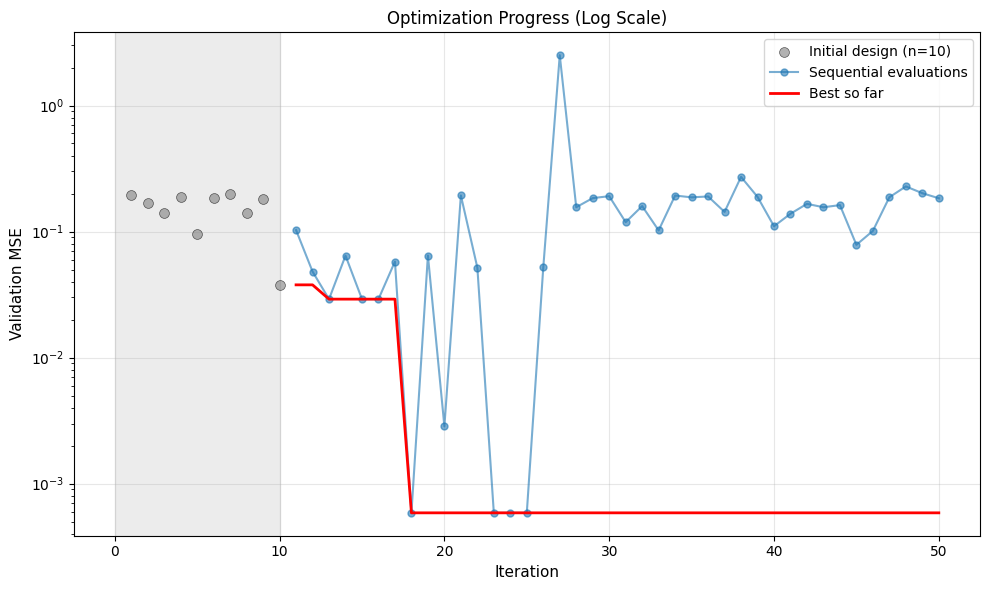

In [12]:
#| label: pinn-optimization-history-pinn2
optimizer.plot_progress(log_y=True, ylabel="Validation MSE")

## Surrogate Visualization

Visualize the surrogate model's learned response surface for the most important hyperparameter combinations:

Plotting surrogate contours for top 3 most important parameters:
  activation: importance = 40.87% (type: factor)
  alpha: importance = 17.76% (type: num)
  num_layers: importance = 14.88% (type: int)

Generating 3 surrogate plots...
  Plotting activation vs alpha


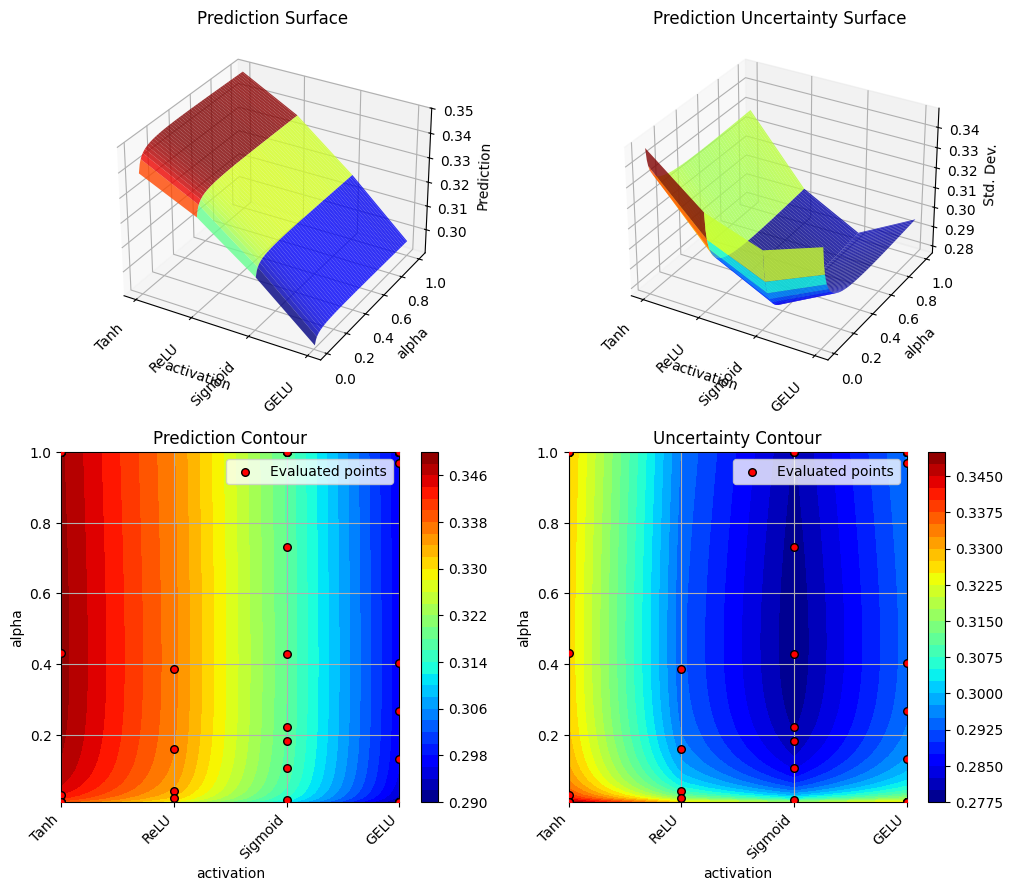

  Plotting activation vs num_layers


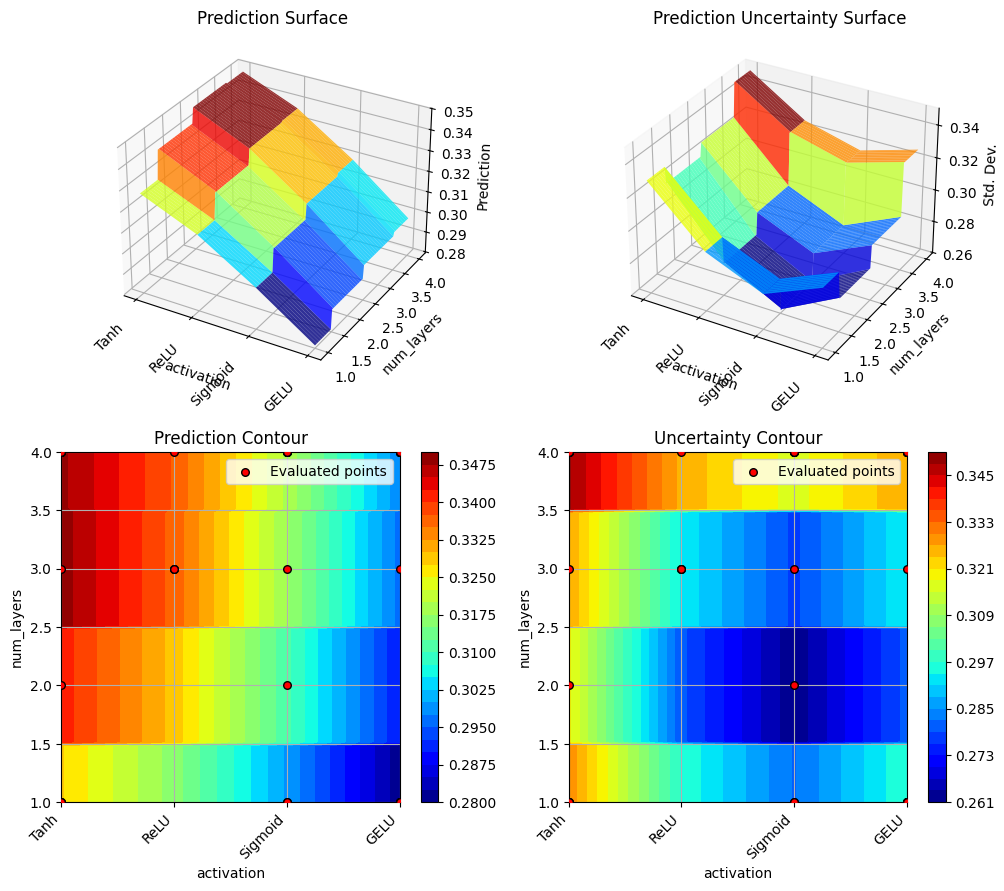

  Plotting alpha vs num_layers


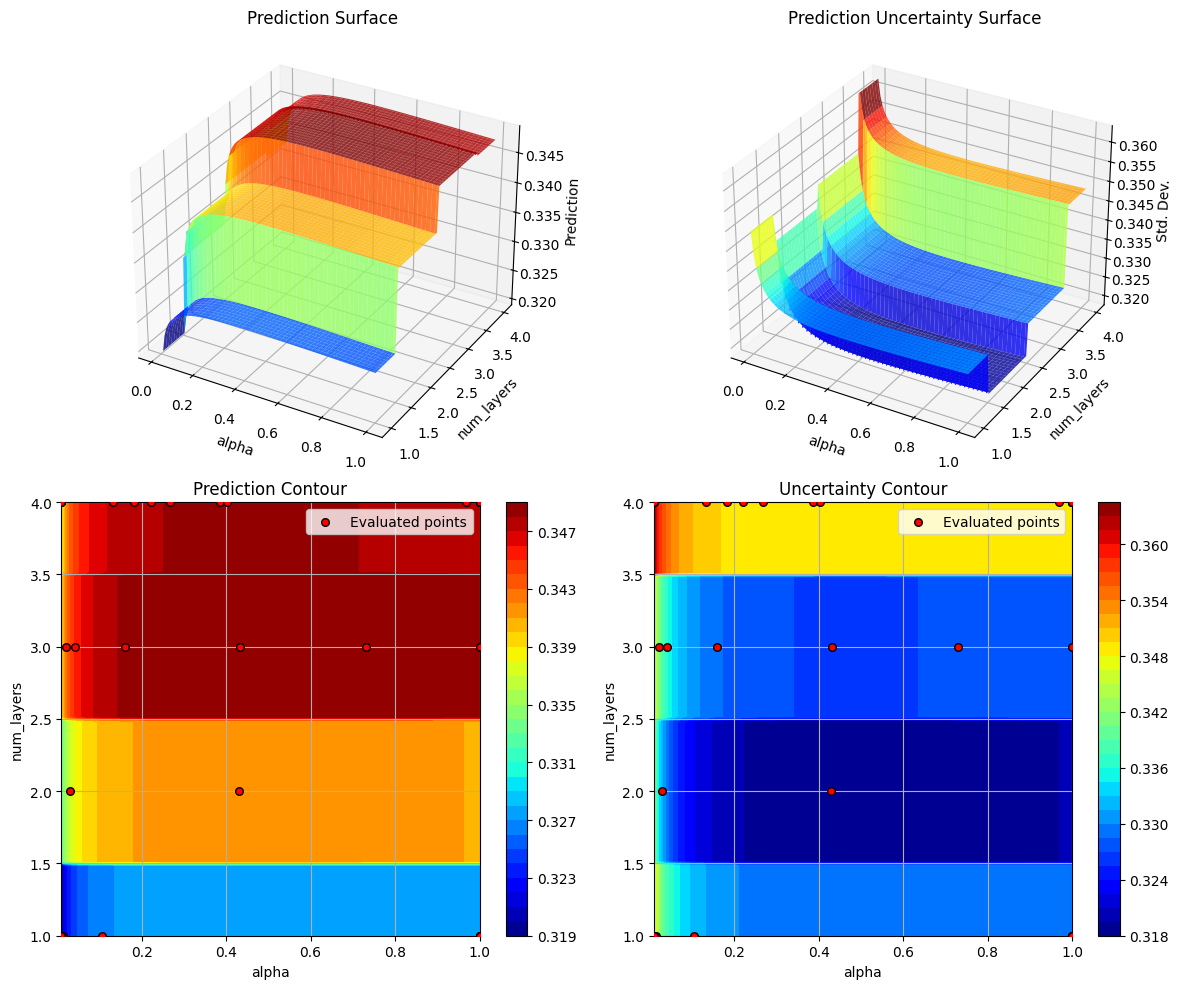

In [13]:
#| label: pinn-surrogate-visualization-pinn2
# Plot top 3 most important hyperparameter combinations
optimizer.plot_important_hyperparameter_contour(max_imp=3)

## Parameter Distribution Analysis

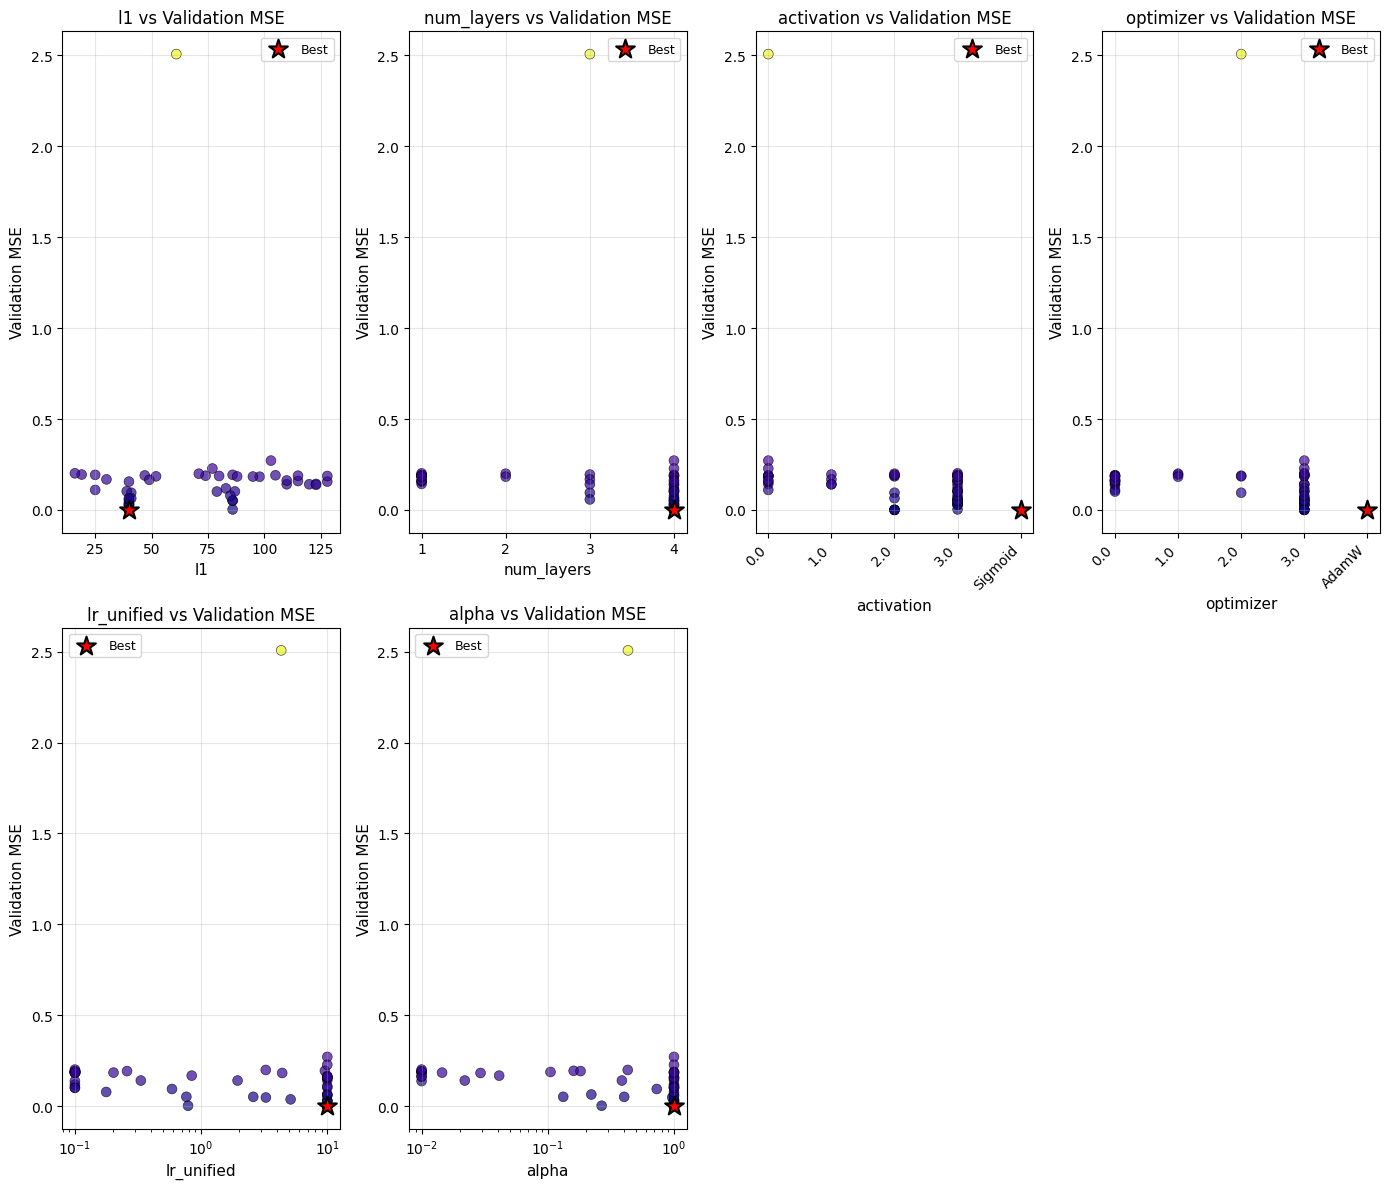

In [14]:
#| label: pinn-parameter-scatter-pinn2
optimizer.plot_parameter_scatter(
    result,
    ylabel="Validation MSE",
    cmap="plasma",
    figsize=(14, 12)
)

# Train Final Model with Best Hyperparameters

Now let's train a final model with the optimized hyperparameters using DataLoaders:

Training final model with best hyperparameters using DataLoaders...
Training for 30,000 epochs...
  Epoch 5000/30000: Avg Loss = 0.004099
  Epoch 10000/30000: Avg Loss = 0.005142
  Epoch 15000/30000: Avg Loss = 0.003295
  Epoch 20000/30000: Avg Loss = 0.002166
  Epoch 25000/30000: Avg Loss = 0.001498
  Epoch 30000/30000: Avg Loss = 0.008092
Training completed!


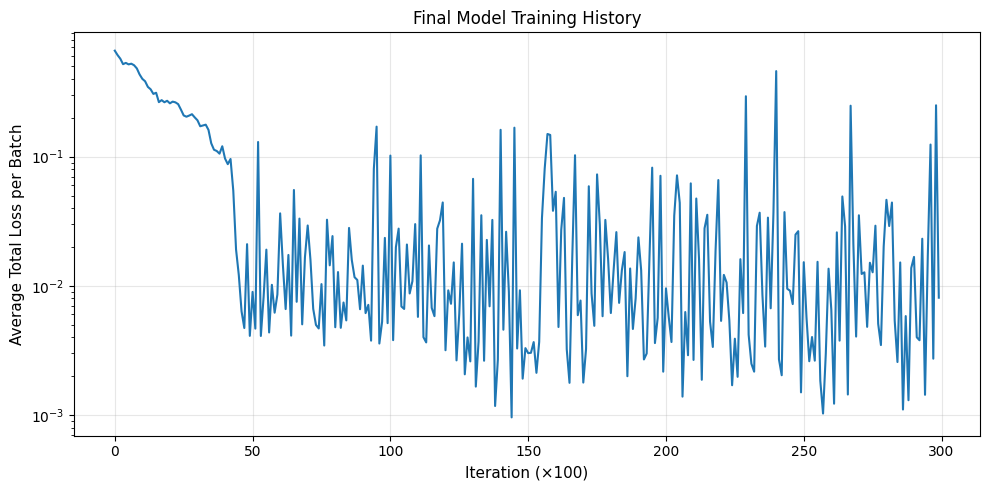

In [15]:
#| label: pinn-final-model-training-pinn2
print("Training final model with best hyperparameters using DataLoaders...")
print(f"Training for 30,000 epochs...")

# Set seed for reproducibility
torch.manual_seed(42)

# Create DataLoaders for final training
final_batch_size = 16
train_loader_final = DataLoader(
    train_dataset,
    batch_size=final_batch_size,
    shuffle=True,
    num_workers=0
)

collocation_loader_final = DataLoader(
    collocation_dataset,
    batch_size=len(collocation_dataset),
    shuffle=False,
    num_workers=0
)

# Create model with best hyperparameters
final_model = LinearRegressor(
    input_dim=1,
    output_dim=1,
    l1=best_l1,
    num_hidden_layers=best_num_layers,
    activation=best_activation,
    lr=best_lr_unified
)

optimizer_final = final_model.get_optimizer(best_optimizer)

# Training with history tracking
loss_history = []
n_epochs_final = 30000

for epoch in range(n_epochs_final):
    final_model.train()
    epoch_loss = 0.0
    
    # Get collocation points
    t_physics_batch = next(iter(collocation_loader_final))
    t_physics_batch = t_physics_batch.requires_grad_(True)
    
    # Iterate over training batches
    for batch_t, batch_y in train_loader_final:
        optimizer_final.zero_grad()
        
        # Data Loss
        y_pred = final_model(batch_t)
        loss_data = torch.mean((y_pred - batch_y)**2)
        
        # Physics Loss
        y_physics = final_model(t_physics_batch)
        dy_dt = torch.autograd.grad(
            y_physics,
            t_physics_batch,
            torch.ones_like(y_physics),
            create_graph=True,
            retain_graph=True
        )[0]
        
        physics_residual = dy_dt + 0.1 * y_physics - torch.sin(np.pi * t_physics_batch / 2)
        loss_physics = torch.mean(physics_residual**2)
        
        # Total Loss
        loss = loss_data + best_alpha * loss_physics
        loss.backward()
        optimizer_final.step()
        
        epoch_loss += loss.item()
    
    # Record average loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        avg_loss = epoch_loss / len(train_loader_final)
        loss_history.append(avg_loss)
    
    if (epoch + 1) % 5000 == 0:
        avg_loss = epoch_loss / len(train_loader_final)
        print(f"  Epoch {epoch+1}/{n_epochs_final}: Avg Loss = {avg_loss:.6f}")

print("Training completed!")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, linewidth=1.5)
plt.xlabel('Iteration (×100)', fontsize=11)
plt.ylabel('Average Total Loss per Batch', fontsize=11)
plt.title('Final Model Training History', fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Evaluate Final Model

In [16]:
#| label: pinn-final-model-evaluation-pinn2
# Create validation DataLoader for evaluation
val_loader_final = DataLoader(
    val_dataset,
    batch_size=len(val_dataset),
    shuffle=False,
    num_workers=0
)

# Evaluate on validation set
final_model.eval()
with torch.no_grad():
    # Validation MSE using DataLoader
    val_mse_total = 0.0
    for batch_t, batch_y in val_loader_final:
        y_pred = final_model(batch_t)
        val_mse_total += torch.mean((y_pred - batch_y)**2).item()
    final_val_mse = val_mse_total / len(val_loader_final)
    
    # Predict on full domain for visualization
    y_pred_full = final_model(x_exact)
    full_mse = torch.mean((y_pred_full - y_exact)**2).item()
    
    # Compute maximum absolute error
    max_error = torch.max(torch.abs(y_pred_full - y_exact)).item()

print("\nFinal Model Performance:")
print("-" * 50)
print(f"  Validation MSE: {final_val_mse:.6f}")
print(f"  Full domain MSE: {full_mse:.6f}")
print(f"  Maximum absolute error: {max_error:.6f}")


Final Model Performance:
--------------------------------------------------
  Validation MSE: 0.005453
  Full domain MSE: 0.005401
  Maximum absolute error: 0.174932


# Visualize Final Solution

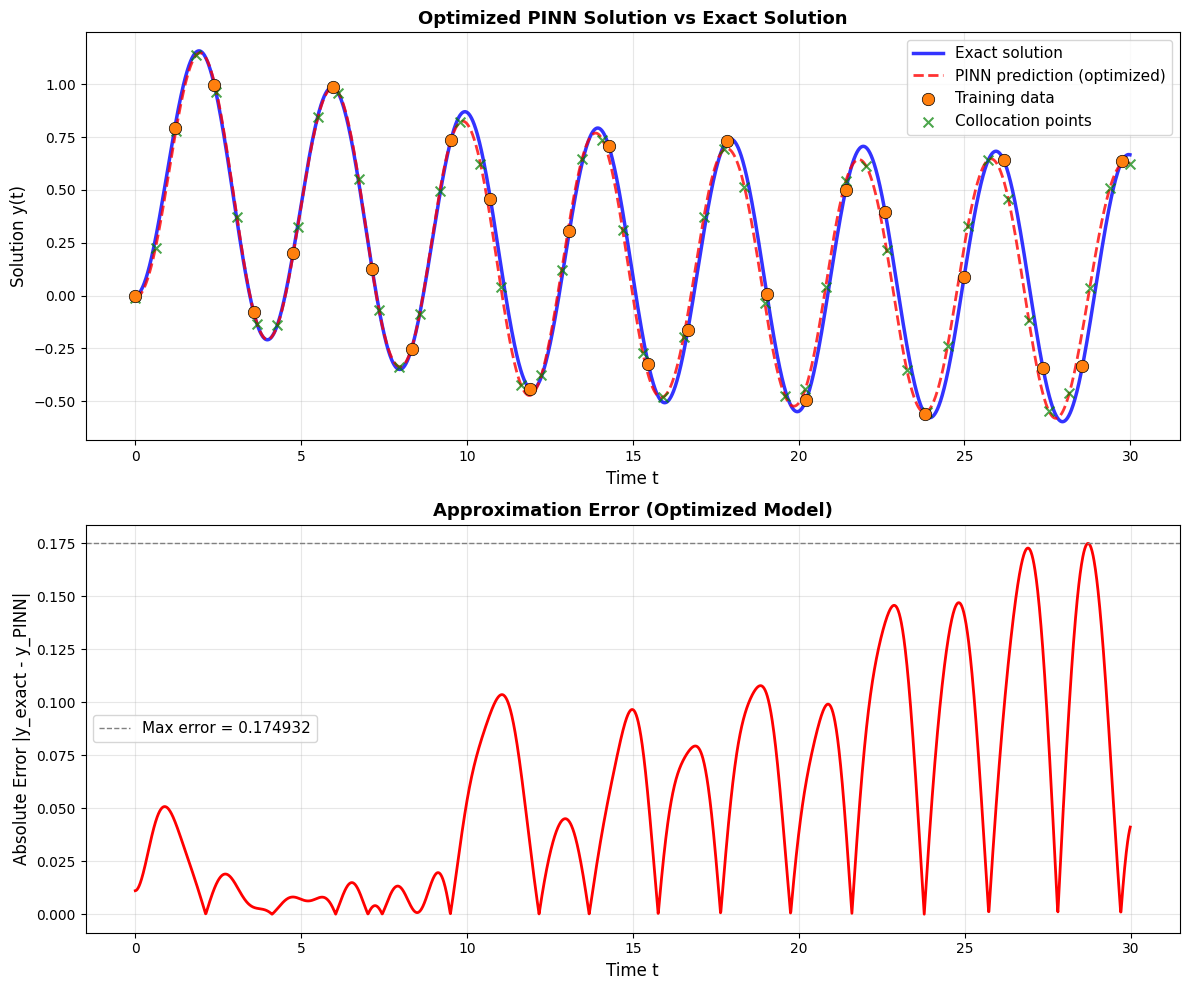

In [17]:
#| label: pinn-final-model-visualization-pinn2
# Generate predictions
final_model.eval()
with torch.no_grad():
    y_pred = final_model(x_exact)

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Solution comparison
ax1 = axes[0]
ax1.plot(x_exact.numpy(), y_exact.numpy(), 'b-', linewidth=2.5, 
         label='Exact solution', alpha=0.8)
ax1.plot(x_exact.numpy(), y_pred.numpy(), 'r--', linewidth=2, 
         label='PINN prediction (optimized)', alpha=0.8)

# Plot training data from dataset
ax1.scatter(train_dataset.t.numpy(), train_dataset.y.numpy(), 
            color='tab:orange', s=80, label='Training data', 
            zorder=5, edgecolors='black', linewidth=0.5)

# Plot collocation points
t_collocation = collocation_dataset.t.detach()
ax1.scatter(t_collocation.numpy(), 
            final_model(t_collocation).detach().numpy(),
            color='green', marker='x', s=50, 
            label='Collocation points', alpha=0.7, zorder=4)

ax1.set_xlabel('Time t', fontsize=12)
ax1.set_ylabel('Solution y(t)', fontsize=12)
ax1.set_title('Optimized PINN Solution vs Exact Solution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Error
ax2 = axes[1]
error = torch.abs(y_pred - y_exact)
ax2.plot(x_exact.numpy(), error.numpy(), 'r-', linewidth=2)
ax2.axhline(y=max_error, color='gray', linestyle='--', linewidth=1, 
            label=f'Max error = {max_error:.6f}')
ax2.set_xlabel('Time t', fontsize=12)
ax2.set_ylabel('Absolute Error |y_exact - y_PINN|', fontsize=12)
ax2.set_title('Approximation Error (Optimized Model)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison with Baseline

Let's compare the optimized configuration with a baseline:

Training baseline model for comparison...

Baseline Configuration:
  l1: 32
  num_layers: 3
  activation: Tanh
  optimizer: Adam
  lr_unified: 3.0
  alpha: 0.06

Validation MSE Comparison:
--------------------------------------------------
  Baseline: 0.058316
  Optimized: 0.000587
  Improvement: 99.0%


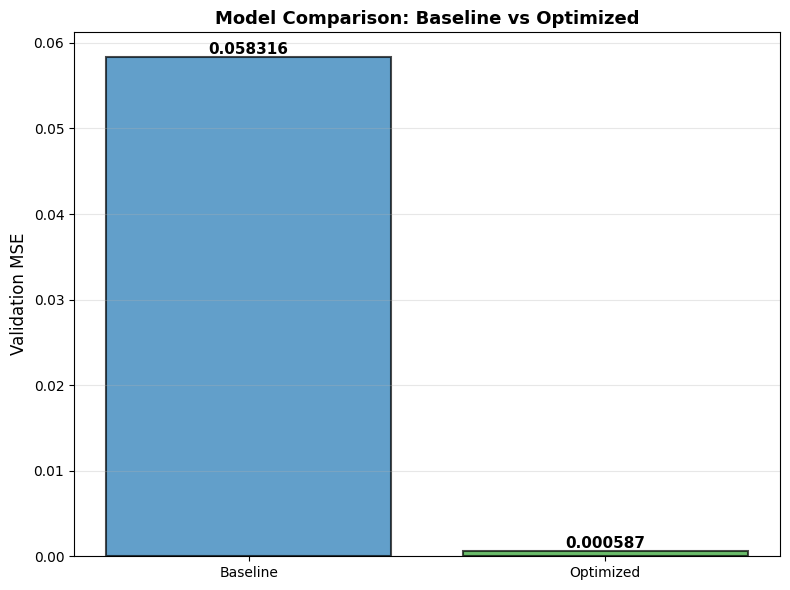

In [18]:
#| label: pinn-baseline-comparison-pinn2
print("Training baseline model for comparison...")

# Baseline configuration (from basic PINN demo)
baseline_config = {
    'l1': 32,
    'num_layers': 3,
    'activation': 'Tanh',
    'optimizer': 'Adam',
    'lr_unified': 3.0,
    'alpha': 0.06
}

print(f"\nBaseline Configuration:")
for key, val in baseline_config.items():
    print(f"  {key}: {val}")

# Train baseline
baseline_error = train_pinn(
    l1=baseline_config['l1'],
    num_layers=baseline_config['num_layers'],
    activation=baseline_config['activation'],
    optimizer_name=baseline_config['optimizer'],
    lr_unified=baseline_config['lr_unified'],
    alpha=baseline_config['alpha'],
    n_epochs=N_EPOCHS,
    verbose=False
)

print(f"\nValidation MSE Comparison:")
print("-" * 50)
print(f"  Baseline: {baseline_error:.6f}")
print(f"  Optimized: {best_val_error:.6f}")
print(f"  Improvement: {(1 - best_val_error/baseline_error)*100:.1f}%")

# Bar plot comparison
fig, ax = plt.subplots(figsize=(8, 6))
configs = ['Baseline', 'Optimized']
errors = [baseline_error, best_val_error]
colors = ['tab:blue', 'tab:green']

bars = ax.bar(configs, errors, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, error in zip(bars, errors):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{error:.6f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Validation MSE', fontsize=12)
ax.set_title('Model Comparison: Baseline vs Optimized', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Hyperparameter Sensitivity Analysis

Let's analyze how sensitive the model is to each hyperparameter using the enhanced `plot_parameter_scatter()` method with Spearman correlation:

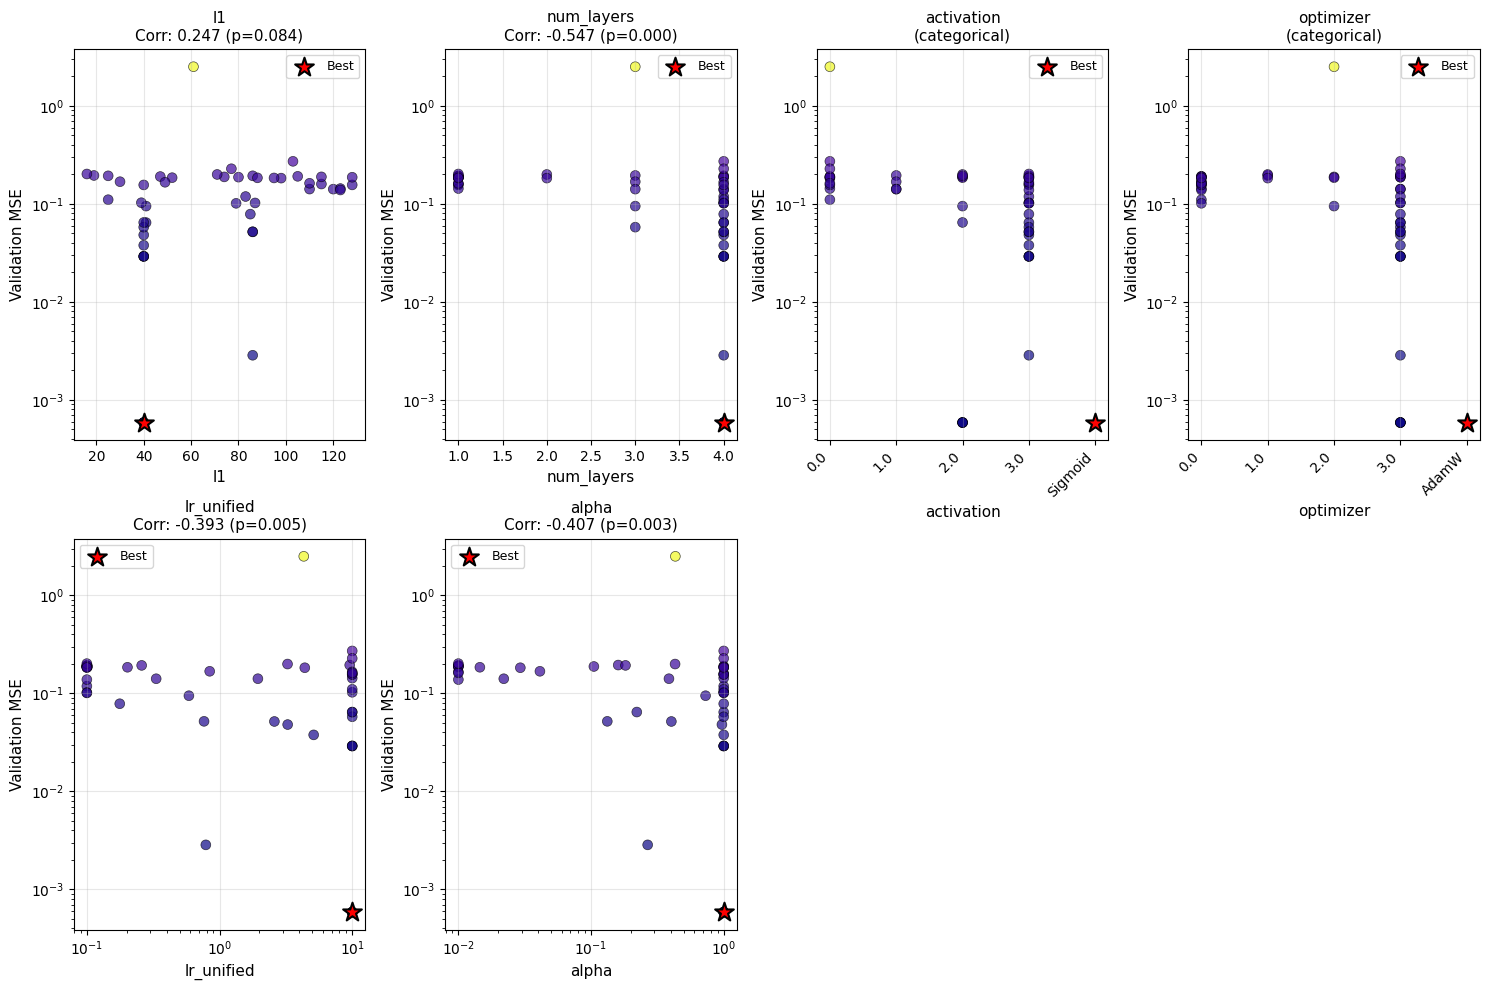

In [19]:
#| label: pinn-sensitivity-analysis-pinn2
# Use the enhanced plot_parameter_scatter method with correlation display
optimizer.plot_parameter_scatter(
    result,
    ylabel="Validation MSE",
    cmap="plasma",
    figsize=(15, 10),
    show_correlation=True,
    log_y=True
)

## Sensitivity Analysis (Spearman Correlation)

In [20]:
# Use the new sensitivity_spearman() method for tabular output
optimizer.sensitivity_spearman()


Sensitivity Analysis (Spearman Correlation):
--------------------------------------------------
  l1                  : +0.247 (p=0.084)
  num_layers          : -0.547 (p=0.000) ***
  activation          : (categorical variable, use visual inspection)
  optimizer           : (categorical variable, use visual inspection)
  lr_unified          : -0.393 (p=0.005) **
  alpha               : -0.407 (p=0.003) **


# Summary

## Key Findings

In [21]:
#| label: pinn-summary-pinn2
# Get optimization history for statistics
history = optimizer.y_

print("\n" + "="*70)
print("HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*70)

print("\n1. BEST CONFIGURATION FOUND:")
print(f"   - Neurons per layer (l1): {best_l1}")
print(f"   - Number of hidden layers: {best_num_layers}")
print(f"   - Activation function: {best_activation}")
print(f"   - Optimizer: {best_optimizer}")
print(f"   - Learning rate: {best_lr_unified:.4f}")
print(f"   - Physics weight (alpha): {best_alpha:.4f}")

print("\n2. PERFORMANCE:")
print(f"   - Validation MSE: {best_val_error:.6f}")
print(f"   - Full domain MSE: {full_mse:.6f}")
print(f"   - Maximum absolute error: {max_error:.6f}")

print("\n3. OPTIMIZATION STATISTICS:")
print(f"   - Total evaluations: {result.nfev}")
print(f"   - Initial best: {history[0]:.6f}")
print(f"   - Final best: {best_val_error:.6f}")
print(f"   - Improvement: {(1 - best_val_error/history[0])*100:.1f}%")

print("\n4. COMPARISON TO BASELINE:")
print(f"   - Baseline MSE: {baseline_error:.6f}")
print(f"   - Optimized MSE: {best_val_error:.6f}")
print(f"   - Improvement: {(1 - best_val_error/baseline_error)*100:.1f}%")

print("\n" + "="*70)


HYPERPARAMETER OPTIMIZATION SUMMARY

1. BEST CONFIGURATION FOUND:
   - Neurons per layer (l1): 40
   - Number of hidden layers: 4
   - Activation function: Sigmoid
   - Optimizer: AdamW
   - Learning rate: 10.0000
   - Physics weight (alpha): 1.0000

2. PERFORMANCE:
   - Validation MSE: 0.000587
   - Full domain MSE: 0.005401
   - Maximum absolute error: 0.174932

3. OPTIMIZATION STATISTICS:
   - Total evaluations: 50
   - Initial best: 0.194793
   - Final best: 0.000587
   - Improvement: 99.7%

4. COMPARISON TO BASELINE:
   - Baseline MSE: 0.058316
   - Optimized MSE: 0.000587
   - Improvement: 99.0%



## Recommendations

Based on the hyperparameter optimization results:

1. **Network Architecture**:
   - The optimal architecture was found with `{best_l1}` neurons and `{best_num_layers}` hidden layers
   - Best activation function: `{best_activation}`
   - This balances model capacity with training efficiency

2. **Optimizer Selection**:
   - Best optimizer: `{best_optimizer}`
   - Different optimizers have different convergence characteristics for PINNs

3. **Learning Rate**:
   - Optimal unified learning rate: `{best_lr_unified:.4f}`
   - This translates to an actual Adam learning rate of `{best_lr_unified * 0.001:.6f}`

4. **Physics Loss Weight**:
   - Optimal alpha: `{best_alpha:.4f}`
   - This balances data fitting with physics constraint satisfaction

5. **Training Strategy**:
   - Start with a broad search space to explore different architectures
   - Use `var_trans` with "log10" for learning rate and physics weight parameters
   - This enables efficient exploration of log-scale parameters without manual transformations
   - Validate on held-out data to prevent overfitting to training points

6. **Benefits of var_trans and Factor Variables**:
   - **Factor variables**: Categorical choices (activation, optimizer) handled automatically
   - SpotOptim maps strings to integers internally and back to strings in results
   - **Cleaner code**: No manual `10**x` conversions in objective function
   - **Fewer errors**: Eliminates confusion about which scale values are in
   - **Better optimization**: Searches efficiently in transformed space
   - **Easier interpretation**: All results displayed in original scale

## Using These Results

To use the optimized configuration in your own PINN problems:

```python
# Create optimized PINN
model = LinearRegressor(
    input_dim=1,
    output_dim=1,
    l1={best_l1},
    num_hidden_layers={best_num_layers},
    activation="{best_activation}",
    lr={best_lr_unified:.4f}
)

optimizer = model.get_optimizer("{best_optimizer}")

# Use alpha={best_alpha:.4f} for physics loss weight
loss = data_loss + {best_alpha:.4f} * physics_loss
```

## Using var_trans for Your Hyperparameter Optimization

When setting up optimization for your own PINN problems:

```python
from spotoptim import SpotOptim

# Define search space with factor variables and log-scale parameters
bounds = [
    (16, 128),                                    # neurons (integer)
    (1, 4),                                       # layers (integer)
    ("Tanh", "ReLU", "Sigmoid", "GELU"),       # activation (factor)
    ("Adam", "SGD", "RMSprop", "AdamW"),        # optimizer (factor)
    (0.1, 10.0),                                  # learning rate (log-scale)
    (0.01, 1.0)                                   # physics weight (log-scale)
]

var_type = ["int", "int", "factor", "factor", "num", "num"]
var_trans = [None, None, None, None, "log10", "log10"]

opt = SpotOptim(
    fun=your_objective_function,
    bounds=bounds,
    var_type=var_type,
    var_trans=var_trans,  # Automatic log-scale and factor handling!
    max_iter=MAX_ITER,
    n_initial=10
)

result = opt.optimize()
```

Your objective function receives parameters in **original scale** - no manual transformations needed!

## Future Directions

Consider exploring:

1. **Adaptive physics weights** that change during training
2. **Architecture search** including skip connections or residual blocks
3. **Batch size optimization** as an additional hyperparameter
4. **Multi-objective optimization** balancing accuracy and computational cost
5. **Transfer learning** from pre-optimized configurations
6. **Learning rate schedules** with different decay strategies

---

**Note**: The specific optimal values depend on the problem, data distribution, and computational budget. Always validate results on held-out test data.